In [1]:
# работа с данными
import numpy as np
import pandas as pd

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


# machine learning
from sklearn.model_selection import train_test_split,  GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Отображаем все столбцы в датасете
pd.set_option("display.max_columns", None )

In [2]:
# Loading the dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# Target
Transported = df_train['Transported'].to_numpy()
# drop target from df_train
df_train.drop('Transported', axis=1, inplace=True)
# concat train and test
dataset = pd.concat([df_train, df_test], sort= True)
# make copy
df = dataset.copy()
# List of dataframes
dfs = [df_train, df_test]
# Give names to each dataframe
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df.name = 'All Set'


In [3]:
Transported

array([False,  True, False, ...,  True, False,  True])

In [4]:
print('Количество обучающих объектов = {}'.format(df_train.shape[0]))
print('Количество тестовых объектов = {}\n'.format(df_test.shape[0]))
print('Размерность обучающих данных (X Shape) = {}'.format(df_train.shape))
print('Размерность целевой переменной (y Shape) = {}\n'.format(Transported.shape[0]))
print('Размерность тестовая данных (X Shape) = {}'.format(df_test.shape))
print('Размерность целевой переменной теста (y Shape) = {}\n'.format(df_test.shape[0]))

print('df_train.columns\n', df_train.columns.to_list())
print('df_test.columns\n', df_test.columns.to_list())

Количество обучающих объектов = 8693
Количество тестовых объектов = 4277

Размерность обучающих данных (X Shape) = (8693, 13)
Размерность целевой переменной (y Shape) = 8693

Размерность тестовая данных (X Shape) = (4277, 13)
Размерность целевой переменной теста (y Shape) = 4277

df_train.columns
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
df_test.columns
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


## Анализ данных

* `PassengerId` — уникальный идентификатор для каждого пассажира. 
Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, 
с которой путешествует пассажир, а pp — его номер в группе. 
Люди в группе часто являются членами семьи, но не всегда.

* `HomePlanet` — планета, с которой вылетел пассажир, обычно планета его постоянного проживания.

* `CryoSleep` — указывает, выбрал ли пассажир режим анабиоза на время путешествия. 
Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.

* `Cabin` — номер каюты, в которой находится пассажир. 
Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, 
либо S для правого борта.

* `Destination` — планета, на которую будет высаживаться пассажир.

* `Age` - возраст пассажира.

* `VIP` - оплатил ли пассажир специальное VIP-обслуживание во время рейса.

* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` — сумма, которую пассажир выставил в счет 
за каждое из многочисленных роскошных удобств космического корабля «Титаник».

* `Name` - Имя и фамилия пассажира.

* `Transported` — был ли пассажир перенесен в другое измерение. Это цель, столбец, 
который вы пытаетесь предсказать.

In [5]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} Количество пропущенных значений: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(df)

Age Количество пропущенных значений: 270
Cabin Количество пропущенных значений: 299
CryoSleep Количество пропущенных значений: 310
Destination Количество пропущенных значений: 274
FoodCourt Количество пропущенных значений: 289
HomePlanet Количество пропущенных значений: 288
Name Количество пропущенных значений: 294
PassengerId Количество пропущенных значений: 0
RoomService Количество пропущенных значений: 263
ShoppingMall Количество пропущенных значений: 306
Spa Количество пропущенных значений: 284
VIP Количество пропущенных значений: 296
VRDeck Количество пропущенных значений: 268




# Пропущенные значения

## Cabin

In [6]:
# Создадим новую колонку с палубой, где из колонки Cabin возьмём первый символ, где каюта не указана - ставим 'M'
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
# Удаляем измененную колонку
df.drop(['Cabin'], inplace=True, axis=1)
# Переместим пассажиров из палубы Т на палубу А
df['Deck'] = np.where((df['Deck'] == 'T'), 'A', df['Deck'])
# Encoding
df = pd.get_dummies(data = df, columns=['Deck'])

## Age

In [7]:
# Заполняем пропущенные значения по медиане
print('Медианный возраст всех пассажиров: {}'.format(df['Age'].median()))
df['Age'] = df['Age'].fillna(df['Age'].median())

Медианный возраст всех пассажиров: 27.0


## CryoSleep

In [8]:
# Переводим колонку CryoSleep в бинарный вид
df['CryoSleep'] = np.where((df['CryoSleep'] == True), 1, df['CryoSleep'])
df['CryoSleep'] = np.where((df['CryoSleep'] == False), 0, df['CryoSleep'])
# Смотрим популярное значение
df['CryoSleep'].value_counts()


0    8079
1    4581
Name: CryoSleep, dtype: int64

In [9]:
# заполняем NaN
df['CryoSleep'] = df['CryoSleep'].fillna(0)
# Encoding
df = pd.get_dummies(data = df, columns=['CryoSleep'])

## Destination

In [10]:
# Смотрим популярное значение
df['Destination'].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [11]:
# заполняем NaN
df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
# Encoding
df = pd.get_dummies(data = df, columns=['Destination'])

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [12]:
# заполняем NaN
df['RoomService'] = df['RoomService'].fillna(df['RoomService'].mean())
df['FoodCourt'] = df['FoodCourt'].fillna(df['FoodCourt'].mean())
df['ShoppingMall'] = df['ShoppingMall'].fillna(df['ShoppingMall'].mean())
df['Spa'] = df['Spa'].fillna(df['Spa'].mean())
df['VRDeck'] = df['VRDeck'].fillna(df['VRDeck'].mean())

## HomePlanet

In [13]:
# Смотрим популярное значение
df['HomePlanet'].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [14]:
# заполняем NaN
df['HomePlanet'] = df['HomePlanet'].fillna('Earth')

## VIP

In [15]:
# Смотрим популярное значение
df['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [16]:
# Переводим колонку CryoSleep в бинарный вид
df['VIP'] = np.where((df['VIP'] == True), 1, df['VIP'])
df['VIP'] = np.where((df['VIP'] == False), 0, df['VIP'])
# заполняем NaN
df['VIP'] = df['VIP'].fillna(0)
# Encoding
df = pd.get_dummies(data = df, columns=['VIP'])

## HomePlanet

In [17]:
# Encoding
df = pd.get_dummies(data = df, columns=['HomePlanet'])

## Passenger Id

In [18]:
# Encoding
df['group'] = [int(row.split('_')[0]) for row in df['PassengerId']]
df['number_in_group'] = [int(row.split('_')[1]) for row in df['PassengerId']]
df.drop('PassengerId',axis=1,inplace=True)

In [19]:
# Encoding
df = pd.get_dummies(data = df, columns=['number_in_group'])

In [20]:

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} Количество пропущенных значений: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(df)

Age Количество пропущенных значений: 0
FoodCourt Количество пропущенных значений: 0
Name Количество пропущенных значений: 294
RoomService Количество пропущенных значений: 0
ShoppingMall Количество пропущенных значений: 0
Spa Количество пропущенных значений: 0
VRDeck Количество пропущенных значений: 0
Deck_A Количество пропущенных значений: 0
Deck_B Количество пропущенных значений: 0
Deck_C Количество пропущенных значений: 0
Deck_D Количество пропущенных значений: 0
Deck_E Количество пропущенных значений: 0
Deck_F Количество пропущенных значений: 0
Deck_G Количество пропущенных значений: 0
Deck_M Количество пропущенных значений: 0
CryoSleep_0 Количество пропущенных значений: 0
CryoSleep_1 Количество пропущенных значений: 0
Destination_55 Cancri e Количество пропущенных значений: 0
Destination_PSO J318.5-22 Количество пропущенных значений: 0
Destination_TRAPPIST-1e Количество пропущенных значений: 0
VIP_0 Количество пропущенных значений: 0
VIP_1 Количество пропущенных значений: 0
HomePla

In [21]:
df.drop('Name',axis=1,inplace=True)

## Heat Map

In [22]:
#TranspTarget = pd.DataFrame(Transported)
df_train = df.iloc[:8693]#.assign(TranspTarget=TranspTarget.values)
df_test = df.iloc[8693:]

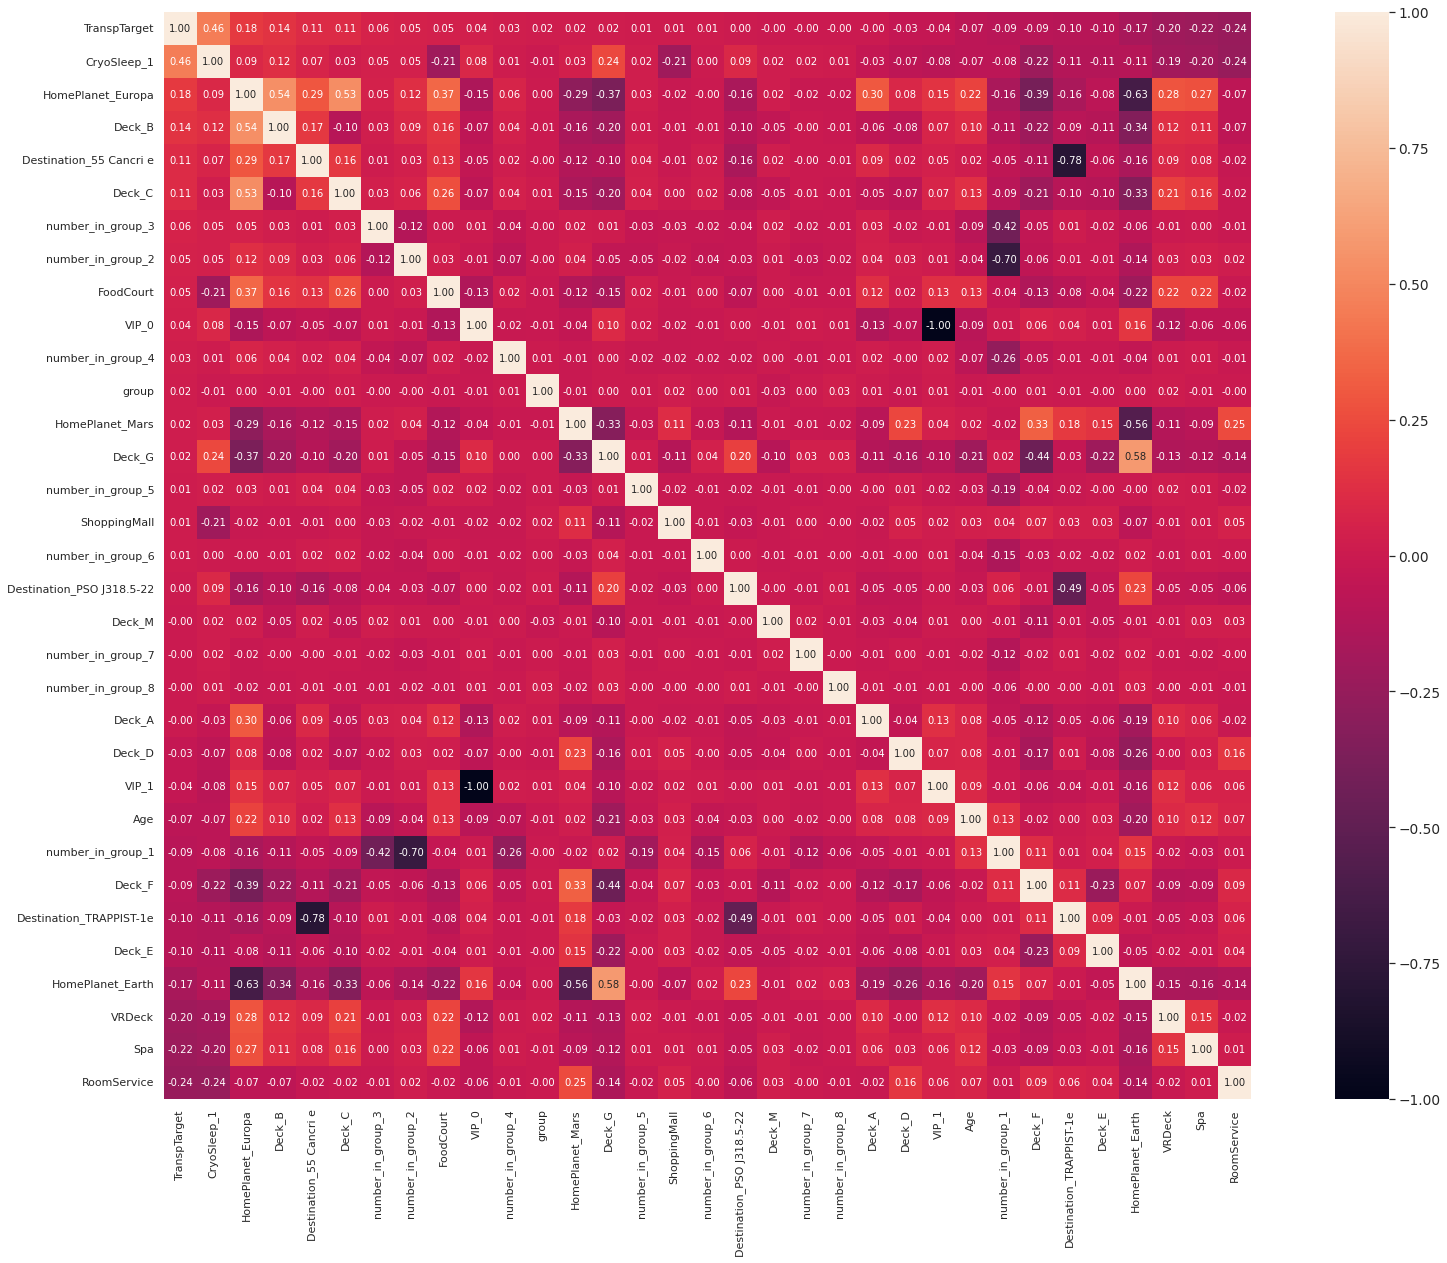

In [25]:
#saleprice correlation matrix
df_train = df_train.astype('float')
f, ax = plt.subplots(figsize=(30, 20))
corrmat = df_train.corr()
k = 33 #кол-во колонок
cols = corrmat.nlargest(k, 'TranspTarget')['TranspTarget'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

# Fit models

In [23]:
#df_train.drop('TranspTarget',axis=1,inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(df_train, Transported, random_state=23, test_size=0.2)

## RandomForestClassifier

In [27]:
clf = RandomForestClassifier()
params = {
    'n_estimators': np.array([100, 6000, 100]),
    'max_features': ['sqrt','log2'],
    'max_depth': np.array([3, 20, 1]),
    'min_samples_split': np.array([2,10,1])
}
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5, 
                  n_jobs=4)

In [29]:
print(cv.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
print(cv.best_params_)

{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
rfc = RandomForestClassifier(max_depth = 20, max_features = 'sqrt', min_samples_split = 10, n_estimators = 6000)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=6000)

In [ ]:
print("train acc:", accuracy_score(rfc.predict(X_train), y_train))
print("test acc:", accuracy_score(rfc.predict(X_valid), y_valid))

train acc: 0.9138625251653725
test acc: 0.8033352501437608


In [ ]:
predict_test = rfc.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred.csv')

## LogisticRegression

In [141]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print("train acc:", accuracy_score(lr.predict(X_train), y_train))
print("test acc:", accuracy_score(lr.predict(X_valid), y_valid))

train acc: 0.7745182628702905
test acc: 0.7987349051178838


In [142]:
predict_test = lr.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_lr.csv')

## Random Forest with Scaler

In [ ]:
df_train = StandardScaler().fit_transform(df_train)

In [ ]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(df_train, TranspTarget, random_state=23, test_size=0.2)

In [ ]:
clf = RandomForestClassifier()
params = {
    'n_estimators': np.array([100, 6000, 100]),
    'max_features': ['sqrt','log2'],
    'max_depth': np.array([3, 20, 1]),
    'min_samples_split': np.array([2,10,1])
}
cv1 = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5, 
                  n_jobs=4)

In [ ]:
cv1.fit(X_train1, y_train1)

In [ ]:
print(cv1.best_score_)

In [ ]:
print(cv1.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 6000}


In [ ]:
rfc1 = RandomForestClassifier(max_depth = 20, max_features = 'sqrt', min_samples_split = 10, n_estimators = 6000)

In [ ]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=6000)

In [ ]:
print("train acc:", accuracy_score(rfc.predict(X_train1), y_train1))
print("test acc:", accuracy_score(rfc.predict(X_valid1), y_valid1))

train acc: 0.5037388553350589
test acc: 0.4974123059229442


In [ ]:
predict_test = rfc1.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_scaler.csv')

## CatBoosting

In [29]:
cb = CatBoostClassifier(iterations = 9000, learning_rate = .08, \
    eval_metric = 'Accuracy', random_seed = 42, \
        logging_level=  'Silent', \
            od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20, \
                l2_leaf_reg = 100, depth = 2, rsm = .6, \
                    random_strength = 2, bagging_temperature = 10)

In [30]:
# fit model
cb.fit(X_train,y_train)

In [31]:
# Best predict score
cb.best_score_

{'learn': {'Accuracy': 0.8619499568593615, 'Logloss': 0.3058225901158649}}

In [88]:
# feature importance
cb.get_feature_importance(prettified=True).head(8)

,Feature Id,Importances
0,Spa,13.736859
1,VRDeck,12.654366
2,RoomService,10.117287
3,CryoSleep_0,9.147648
4,group,7.650776
5,CryoSleep_1,7.150116
6,FoodCourt,6.240924
7,Age,6.009983


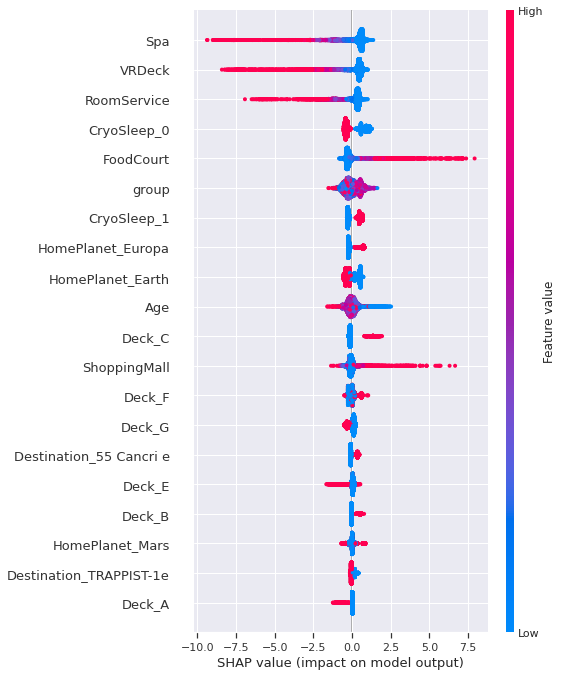

In [64]:
# Теперь воспользуемся библиотекой shap, чтобы визуализировать наши фичи
import shap
explainer = shap.TreeExplainer(cb)
shap_values=explainer.shap_values(df_train, Transported)
shap.summary_plot(shap_values,df_train)

In [65]:
# предсказываем
cb.predict(df_test)

array(['True', 'False', 'True', ..., 'True', 'True', 'True'], dtype=object)

In [66]:
predict_test = cb.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_catboost.csv')

## CatBoost with Feature importance

Собираем feature importance в лист

In [89]:
cat_feature = cb.get_feature_importance(prettified=True).head(8)
cat_feature = cat_feature['Feature Id'].to_list()

создаем новый DataFrame

In [132]:
cat_df = df_train[cat_feature]

In [133]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(cat_df, Transported, random_state=23, test_size=0.2)

In [134]:
cbf = CatBoostClassifier(iterations = 9000, learning_rate = .08, \
    eval_metric = 'Accuracy', random_seed = 42, \
        logging_level=  'Silent', \
            od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20, \
                l2_leaf_reg = 100, depth = 2, rsm = .6, \
                    random_strength = 2, bagging_temperature = 10)

In [135]:
cbf.fit(X_train_cat,y_train_cat)

In [136]:
cbf.best_score_

{'learn': {'Accuracy': 0.8359217716422203, 'Logloss': 0.38128595879733224}}

## Grid cat

In [24]:
# cb = CatBoostClassifier(iterations = 9000, learning_rate = .08, \
#     eval_metric = 'Accuracy', random_seed = 42, \
#         logging_level=  'Silent', \
#             od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20, \
#                 l2_leaf_reg = 100, depth = 2, rsm = .6, \
#                     random_strength = 2, bagging_temperature = 10)

In [38]:
gcb = GradientBoostingClassifier()

{'learn': {'Accuracy': 0.8526028185217142, 'Logloss': 0.31668301614003996}}

In [39]:
params = {
    'n_estimators': np.array([1000, 9000,1000]),
    'min_samples_split': np.array([2,10,1]),
    'min_samples_leaf': np.array([1,5,1]),
    'max_depth': np.array([3,10,1])
}
cb = GridSearchCV(gcb, param_grid=params, cv=5, 
                  n_jobs=4)

In [40]:
# fit model
cb.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'max_depth': array([ 3, 10,  1]),
                         'min_samples_leaf': array([1, 5, 1]),
                         'min_samples_split': array([ 2, 10,  1]),
                         'n_estimators': array([1000, 9000, 1000])})

In [41]:
cb.best_params_

{'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [42]:
cb.best_score_

0.7932141360958681

In [44]:
predict_test = cb.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_gradient.csv')